

<h2><font color="gray">Prepared by: Muhammet Eren KÜÇÜK</font></h2>


<h1 style="color: firebrick; font-family: verdana"><b>Energy Efficiency Estimation from Data</b></h1>

<h2 style="font-family: verdana"><b>2.1: Problem Definition</b></h2>

<p style="font-family: verdana">In this part, we're given a different dataset that consists of 768 samples, regarding the energy efficiency values of different build shapes. We have 8 attributes related to the shapes themselves and 2 output values <b>(heating load, cooling load)</b> that're dependent on the previous 8 values.</p>

<p style="font-family: verdana">Our objective is once again related to creating models, making predictions and comparing them with the actual values in the dataset. But for this time, we'll use <b>k-NN regression</b> instead of classification. Instead of calculating the accuracy, precision and recoil metrics from the previous part, we'll use the <b>mean absolute error (MAE)</b> metric to estimate our model's success with the same k values (1, 3, 5, 7, 9) using 5-fold cross validation once again.</p>

<h2 style="font-family: verdana"><b>2.2: Implementation of k-NN Regression</b></h2>

<p style="font-family: verdana">Like in Part I, we need to import the necessary libraries first.</p>

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

<p style="font-family: verdana">Our k-NN regression class includes a prediction method for both k-NN and weighted k-NN regressions, along with two distance calculations called Euclidian and <b>Mahalanobis</b> (replacing Manhattan from k-NN classification). Our preference was to use Euclidian.</p>

In [11]:
# KNN Regression Implementation
# There are 2 distance ways in wikipedia euclidean and mahalanobis distance.
# We implement both but use euclidean due to take better results.
# You can change load data with colName variable.
class KNN_Regression:
    def __init__(self, k=1):
        self.k = k
    # Predict function with weighted or not
    def predict(self, val_te, x_tr, y_tr, weighted=False):
        if weighted:
            predicted_vals = []
            for k in val_te:
                # Distance to calculate shortest between the 2 points irrespective of the dimensions.
                distances = [self.euclidean_distance(k, x_train, 2) for x_train in x_tr]

                k_indexes = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(distances))[:self.k]]

                k_nearest_vals = []
                for i in range(len(k_indexes)):
                    k_nearest_vals.append(y_tr[k_indexes[i]])

                k_distances = []
                for i in range(len(k_indexes)):
                    k_distances.append(distances[k_indexes[i]])

                weighted_dict = {}

                for i in range(len(k_distances)):
                    k_distances[i] = k_distances[i] + 2

                for i in range(len(k_nearest_vals)):
                    if k_nearest_vals[i] in weighted_dict:
                        weighted_dict[k_nearest_vals[i]] += (1 / k_distances[i])
                    else:
                        weighted_dict[k_nearest_vals[i]] = (1 / k_distances[i])

                val = 0
                divided = 0
                for i in weighted_dict.keys():
                    val += i * weighted_dict[i]
                    divided += weighted_dict[i]

                result = val / divided
                predicted_vals.append(result)

            return np.array(predicted_vals)
        else:
            predicted_vals = []
            for k in val_te:
                distances = [self.euclidean_distance(k, x_train, 2) for x_train in x_tr]

                k_indexes = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(distances))[:self.k]]

                k_nearest_vals = []

                for i in range(len(k_indexes)):
                    k_nearest_vals.append(y_tr[k_indexes[i]])

                avr_val = 0
                for i in range(len(k_nearest_vals)):
                    avr_val += k_nearest_vals[i]

                avr_val = avr_val / len(k_nearest_vals)
                predicted_vals.append(avr_val)

            return np.array(predicted_vals)

    def euclidean_distance(self, row1, row2, p=2):
        distance = 0.0
        for i in range(len(row1) - 1):
            distance += (row1[i] - row2[i]) ** p

        return distance ** (1 / p)

    def mahalanobis_distance(y=None, data=None, cov=None):
        y_mu = y - np.mean(data)

        if not cov:
            cov = np.cov(data.values.T)

        inv_covmat = np.linalg.inv(cov)
        left = np.dot(y_mu, inv_covmat)
        mahal = np.dot(left, y_mu.T)

        return mahal.diagonal()

<h2 style="font-family: verdana"><b>2.3: Reading Data and Analyzing Quantitized Values</b></h2>

<p style="font-family: verdana">To read and parse our dataset, we use the Pandas and Numpy libraries again. Since we now have two output classes instead of one, our drop operations will drop the output class that's not taken into consideration for the current output class' prediction. Because of this, our function will accept either <b>Cooling Load or Heating Load</b> as parameters. The column taken as parameter will be dropped.</p>

In [12]:
def train_test_split(data, split, trainingSet, testSet):
    for x in range(len(data)):
        if np.random.random() < split:
            trainingSet.append(data[x])
        else:
            testSet.append(data[x])



def read_drop_shuffle_parse(colName="Cooling_Load"):
    # reading csv file with pandas
    df = pd.read_csv('energy_efficiency_data.csv')
    # drop column
    df.drop(colName, axis=1)
    # data to numpy array
    df = df.to_numpy()
    # we use random.shuffle due to you said allow it on 3rd week lab lecture
    np.random.shuffle(df)
    return df[:, :-1], df[:, -1], df

<p style="font-family: verdana">We'll also have a min-max value calculation and a normalization function for this part. These values will be used in our predictions and models that include normalization.</p>

In [13]:
def get_min_max(x, min, max):
    mins = []  # stores minimum values of each columns respectively
    maxs = []  # stores maximum values of each columns respectively
    for column_index in range(x.shape[1]):
        min_value = float("inf")
        max_value = float("-inf")

        for row_index in range(x.shape[0]):
            if x[row_index, column_index] < min_value:
                min_value = x[row_index, column_index]
            elif x[row_index, column_index] > max_value:
                max_value = x[row_index, column_index]

        mins.append(min_value)
        maxs.append(max_value)

    min_x = np.array(mins)
    max_x = np.array(maxs)

    if (min == True) and (max == False):
        return min_x

    elif (min == False) and (max == True):
        return max_x
    
    
def normalization(data):
    normalized_data = np.zeros(data.shape)
    min_x, max_x = get_min_max(data, True, False), get_min_max(data, False, True)

    for row_number in range(data.shape[0]):
        for column_number in range(data.shape[1]):
            normalized_data[row_number, column_number] = (data[row_number, column_number] - min_x[column_number]) / (max_x[column_number] - min_x[column_number])

    return normalized_data

<h2 style="font-family: verdana"><b>2.4: Mean Absolute Error Calculation Implementation</b></h2>

<p style="font-family: verdana">This calculation is rather simple compared to the accuracy, precision and recall operations from Part I; since we don't have to deal with the <b>TN, TP, FN and FP</b> values. Instead for each data value, we take the sum of the difference between actual and predicted values as absolute value, then divide it to the number of data values to get the mean absolute error value.</p>

In [14]:
def meanAbsoluteError(actual, predicted):
    N = actual.shape[0]
    mae_val = np.sum(np.absolute(predicted - actual))
    mae_val /= N

    return mae_val

<h2 style="font-family: verdana"><b>2.5: 5-fold Cross Validation</b></h2>

<p style="font-family: verdana">Our predictions will be based on 4 models once again <b>(k-NN / weighted k-NN and with / without normalization)</b> and for the mean absolute value metric, we'll perform our calculations with 5-fold cross validation for 5 different k values. This means that we'll get 20 different mean absolute values total.</p>

In [15]:
def cross_validation():
    validate = int(len(df) * i / cross_value)
    cross_size_value = int(len(df) / cross_value)
    if i == (cross_value - 1):
        x_val = features[validate:, :]
        x_normalized_val = normalized_features[validate:, :]
        y_val = labels[validate:]
    else:
        x_val = features[validate:validate + cross_size_value, :]
        x_normalized_val = normalized_features[validate:validate + cross_size_value, :]
        y_val = labels[validate:validate + cross_size_value]
    x_tr = features[validate + cross_size_value:, :]
    x_normalized_tr = normalized_features[validate + cross_size_value:, :]
    y_tr = labels[validate + cross_size_value:]
    if i != 0:
        x_train2 = features[:validate, :]
        x_normalized_train2 = normalized_features[:validate, :]
        y_train2 = labels[:validate]

        x_tr = np.concatenate((x_tr, x_train2), axis=0)
        x_normalized_tr = np.concatenate((x_normalized_tr, x_normalized_train2), axis=0)
        y_tr = np.concatenate((y_tr, y_train2), axis=0)
    return x_val, x_normalized_val, y_val, x_tr, x_normalized_tr, y_tr

<h2 style="font-family: verdana"><b>2.6: Error Analysis for Regression</b></h2>

In [16]:
# colName = "Cooling_Load"  # UNCOMMENT THIS AND COMMENT NEXT LINE TO GET HEATING LOAD DATA
colName = "Heating_Load"
features, labels, df = read_drop_shuffle_parse(colName)

# normalize data
normalized_features = normalization(features)
avg_mae_uw_un = 0
avg_mae_uw_n = 0
avg_mae_w_un = 0
avg_mae_w_n = 0
cross_value = 5
list_to_plot = []
list_to_plot1 = []
# k - value list (1,3,5,7,9)
# k (5) cross validation
for k in range(1, 11, 2):
    for i in range(cross_value):
        x_validate, x_normalized_validate, y_validate, x_train, x_normalized_train, y_train = cross_validation()

        # Predict Not Weighted - Not Normalized
        model_uw_un = KNN_Regression(k)
        prediction_uw_un = model_uw_un.predict(x_validate, x_train, y_train)
        mae_uw_un = meanAbsoluteError(y_validate, prediction_uw_un)
        avg_mae_uw_un += mae_uw_un

        # Predict Not Weighted - Normalized
        model_uw_n = KNN_Regression(k)
        predictions_uw_n = model_uw_n.predict(x_normalized_validate, x_normalized_train, y_train)
        mae_uw_n = meanAbsoluteError(y_validate, predictions_uw_n)
        avg_mae_uw_n += mae_uw_n

        # Predict Weighted - Not Normalized
        model_w_un = KNN_Regression(k)
        prediction_w_un = model_w_un.predict(x_validate, x_train, y_train, True)
        mae_w_un = meanAbsoluteError(y_validate, prediction_w_un)
        avg_mae_w_un += mae_w_un

        # Predict Weighted - Normalized
        model_w_n = KNN_Regression(k)
        prediction_w_n = model_w_n.predict(x_normalized_validate, x_normalized_train, y_train, True)
        mae_w_n = meanAbsoluteError(y_validate, prediction_w_n)
        avg_mae_w_n += mae_w_n

        list_to_plot.append(mae_uw_n)
        list_to_plot.append(mae_uw_un)
        list_to_plot.append(mae_w_n)
        list_to_plot.append(mae_w_un)

        if i == (cross_value - 1):
            list_to_plot1.append(avg_mae_uw_n / 5)
            list_to_plot1.append(avg_mae_uw_un / 5)
            list_to_plot1.append(avg_mae_w_n / 5)
            list_to_plot1.append(avg_mae_w_un / 5)
            avg_mae_w_n = 0
            avg_mae_w_un = 0
            avg_mae_uw_n = 0
            avg_mae_uw_un = 0


def plot_table(k: int):
    k1_mae_list = list_to_plot[0:20]
    k2_mae_list = list_to_plot[20:40]
    k3_mae_list = list_to_plot[40:60]
    k4_mae_list = list_to_plot[60:80]
    k5_mae_list = list_to_plot[80:]
    k1_average_list = list_to_plot1[0:4]
    k2_average_list = list_to_plot1[4:8]
    k3_average_list = list_to_plot1[8:12]
    k4_average_list = list_to_plot1[12:16]
    k5_average_list = list_to_plot1[16:20]
    mae1list = []
    mae2list = []
    mae3list = []
    mae4list = []
    mae5list = []
    data = []
    if k == 1:
        for i in range(0, 4):
            mae1list.append(k1_mae_list[i])
            mae2list.append(k1_mae_list[i + 4])
            mae3list.append(k1_mae_list[i + 8])
            mae4list.append(k1_mae_list[i + 12])
            mae5list.append(k1_mae_list[i + 16])
        data = [k1_average_list, mae5list, mae4list, mae3list, mae2list, mae1list]
    elif k == 3:
        for i in range(0, 4):
            mae1list.append(k2_mae_list[i])
            mae2list.append(k2_mae_list[i + 4])
            mae3list.append(k2_mae_list[i + 8])
            mae4list.append(k2_mae_list[i + 12])
            mae5list.append(k2_mae_list[i + 16])
        data = [k2_average_list, mae5list, mae4list, mae3list, mae2list, mae1list]
    elif k == 5:
        for i in range(0, 4):
            mae1list.append(k3_mae_list[i])
            mae2list.append(k3_mae_list[i + 4])
            mae3list.append(k3_mae_list[i + 8])
            mae4list.append(k3_mae_list[i + 12])
            mae5list.append(k3_mae_list[i + 16])
        data = [k3_average_list, mae5list, mae4list, mae3list, mae2list, mae1list]
    elif k == 7:
        for i in range(0, 4):
            mae1list.append(k4_mae_list[i])
            mae2list.append(k4_mae_list[i + 4])
            mae3list.append(k4_mae_list[i + 8])
            mae4list.append(k4_mae_list[i + 12])
            mae5list.append(k4_mae_list[i + 16])
        data = [k4_average_list, mae5list, mae4list, mae3list, mae2list, mae1list]
    elif k == 9:
        for i in range(0, 4):
            mae1list.append(k5_mae_list[i])
            mae2list.append(k5_mae_list[i + 4])
            mae3list.append(k5_mae_list[i + 8])
            mae4list.append(k5_mae_list[i + 12])
            mae5list.append(k5_mae_list[i + 16])
        data = [k5_average_list, mae5list, mae4list, mae3list, mae2list, mae1list]
    else:
        print("k value should be 1, 3, 5, 7 or 9")
    print("Plotting table is success for k = " + str(k))
    columns = ('Not Weighted - Not Normalized', 'Not Weighted - Normalized', 'Weighted - Not Normalized', "Weighted - Normalized")
    rows = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5", "Average MAE"]
    
    # THE FOLLOWING LINES OF CODE ARE MARKED AS DOCSTRING TO AVOID PLOTS TO BE SHOWN IN JUPYTER NOTEBOOK OUTPUT

    """
    # Get some pastel shades for the colors
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    n_rows = len(data)

    index = np.arange(len(columns)) + 0.3

    cell_text = []
    for row in range(n_rows):
        plt.plot(index, data[row], color=colors[row])
        y_offset = data[row]
        cell_text.append([x for x in y_offset])
    colors = colors[::-1]
    cell_text.reverse()
    the_table = plt.table(cellText=cell_text,
                          colLabels=columns,
                          rowLabels=rows,
                          rowColours=colors,
                          loc='bottom')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(8)
    plt.subplots_adjust(left=0.25, bottom=0.25)

    plt.ylabel("Mean Absolute Error".format("value_increment"))
    plt.xticks([])
    if colName == "Heating_Load":
        plt.title('Cooling_Load Mean Absolute Error for k = ' + str(k))
    else:
        plt.title('Heating_Load Mean Absolute Error for k = ' + str(k))


    plt.show()

    return "Plotting table is success for k = " + str(k)
    """


# k = 1 table
plot_table(1)
# k = 3 table
plot_table(3)
# k = 5 table
plot_table(5)
# k = 7 table
plot_table(7)
# k = 9 table
plot_table(9)

Plotting table is success for k = 1
Plotting table is success for k = 3
Plotting table is success for k = 5
Plotting table is success for k = 7
Plotting table is success for k = 9


<h3 style="font-family: verdana"><b>2.6.1: Heating Load Results for Different K Values</b></h3>

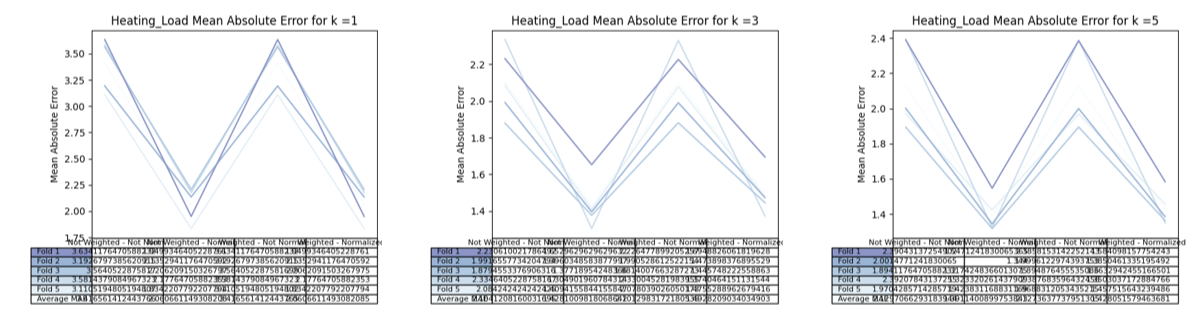

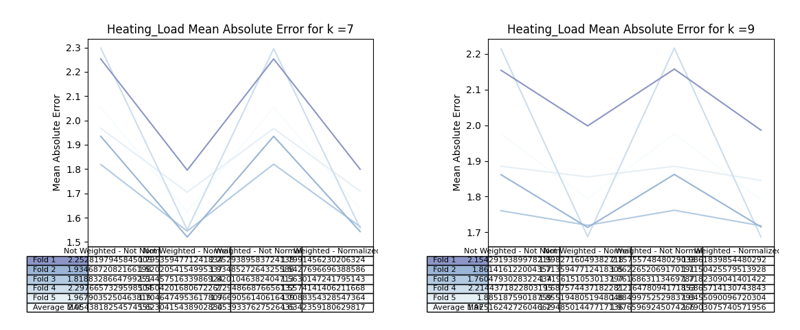

<h3 style="font-family: verdana"><b>2.6.2: Cooling Load Results for Different K Values</b></h3>

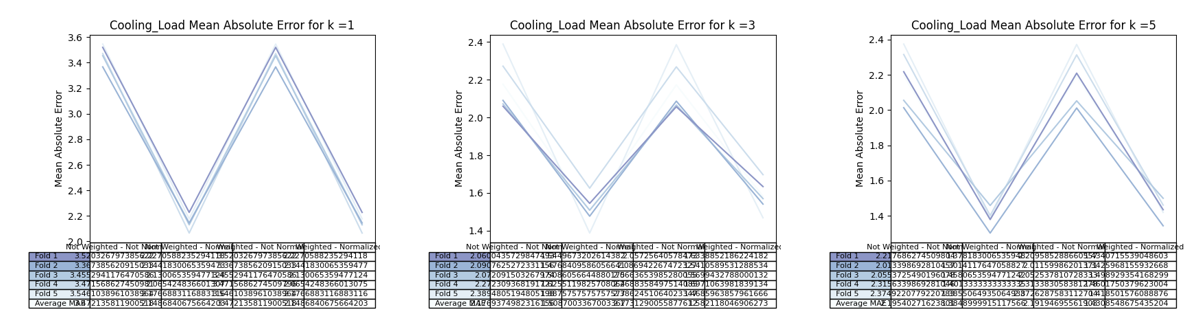

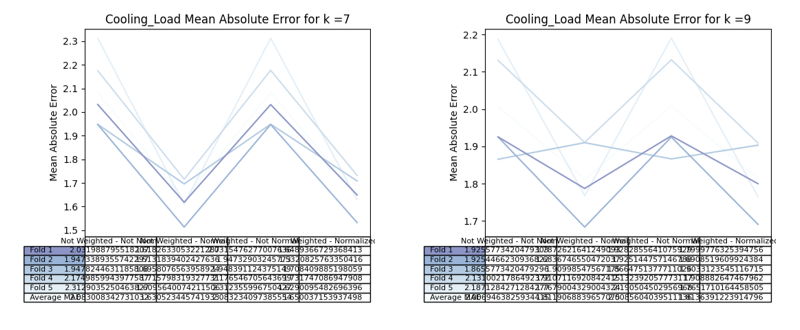

<h3 style="font-family: verdana"><b>2.6.3: MAE Results Collected in Tables</b></h3>

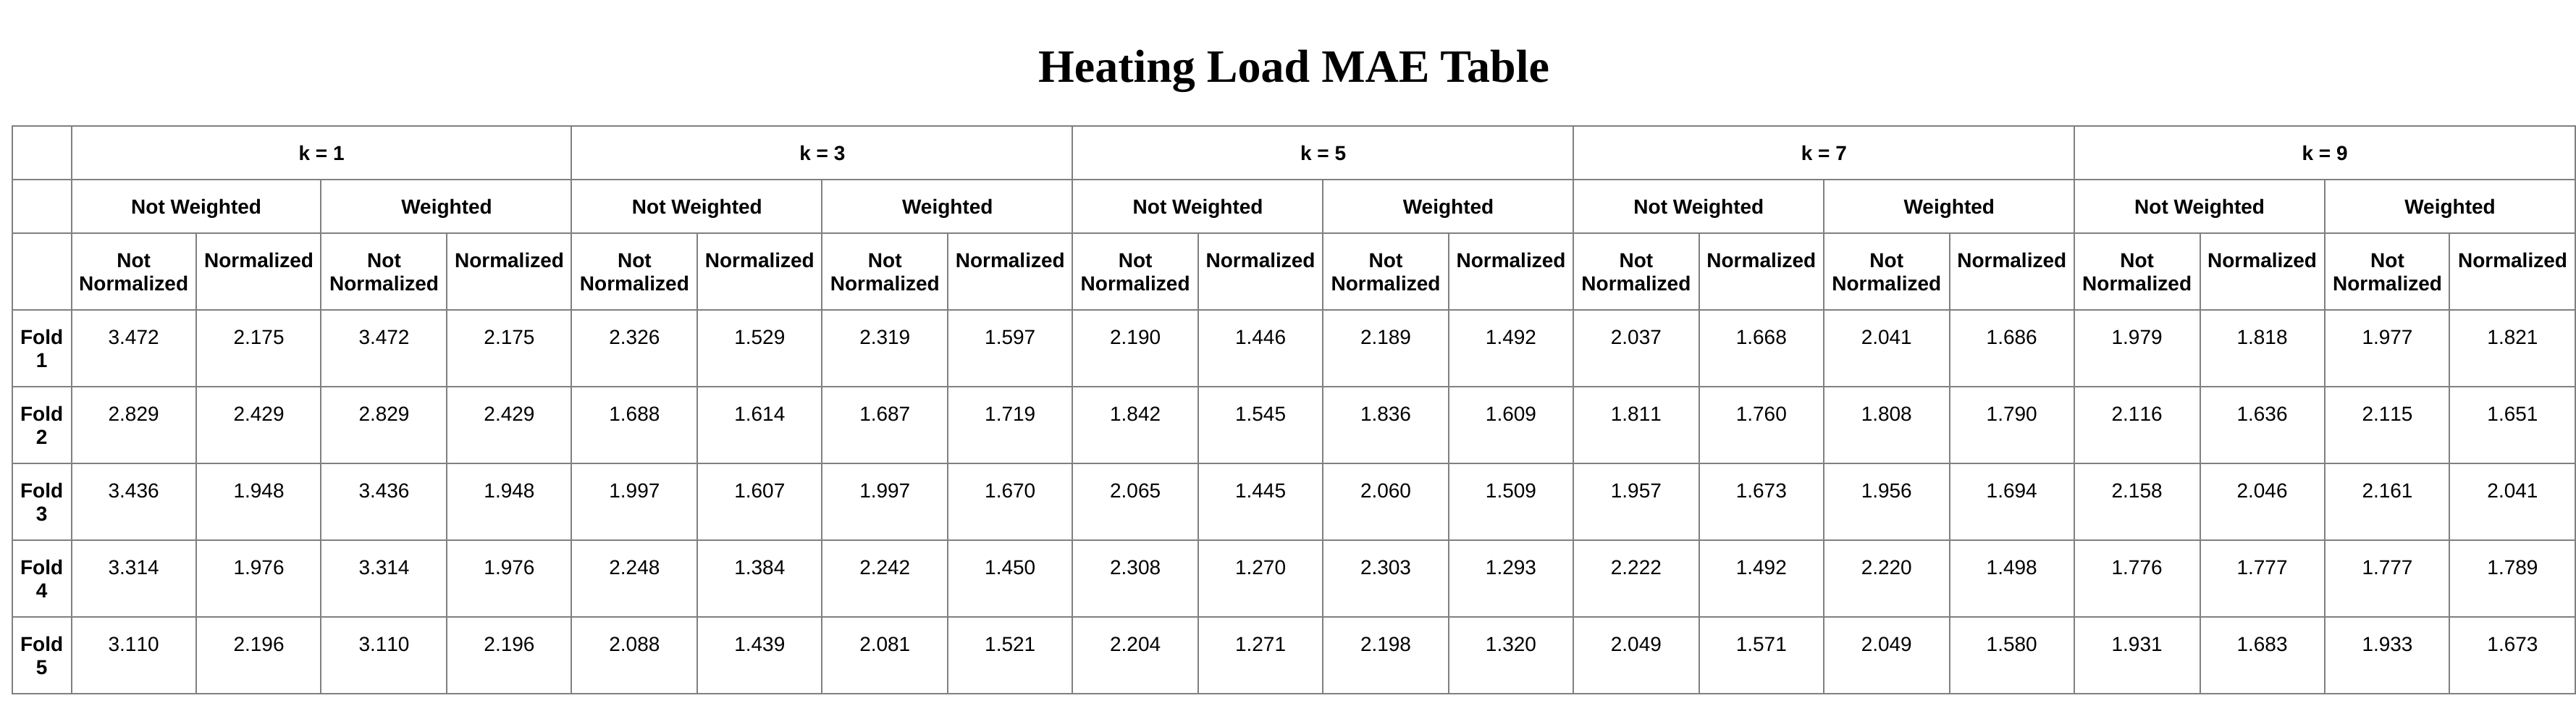

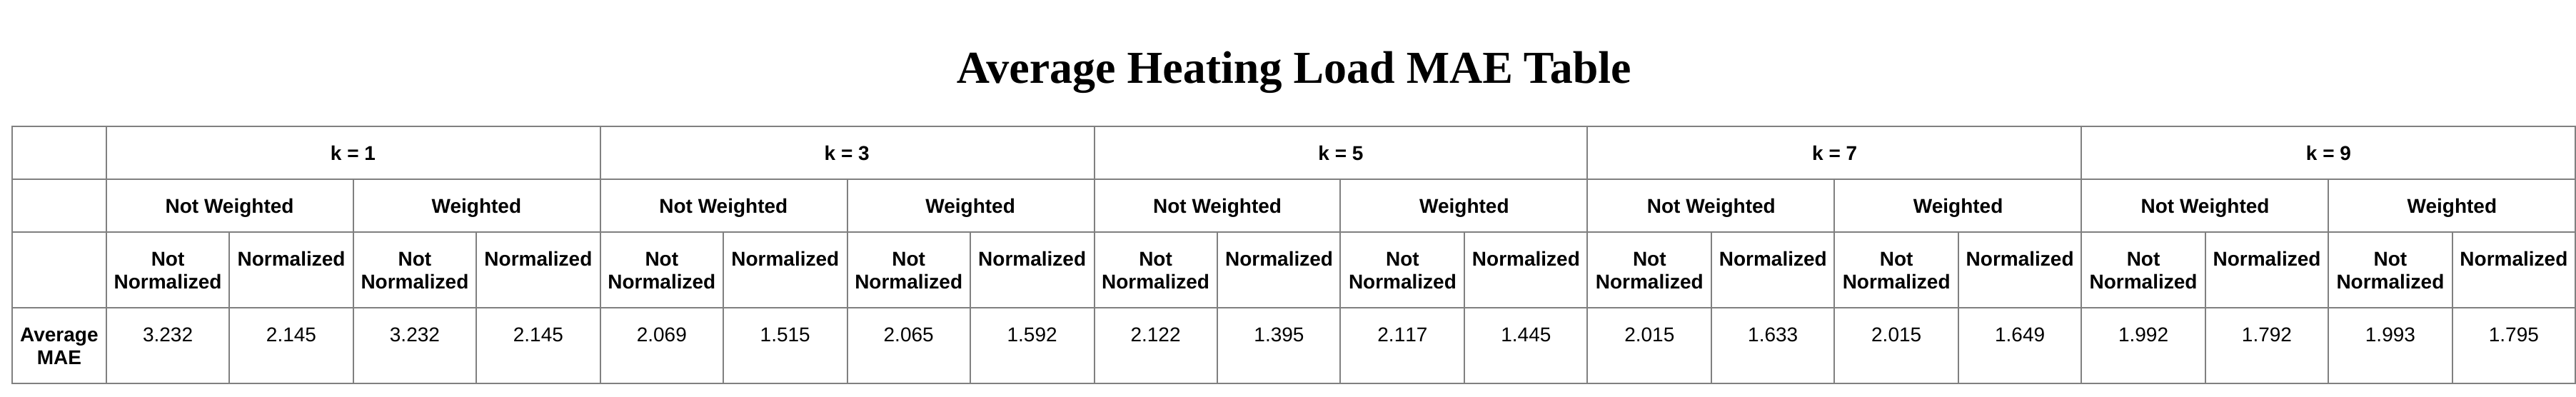

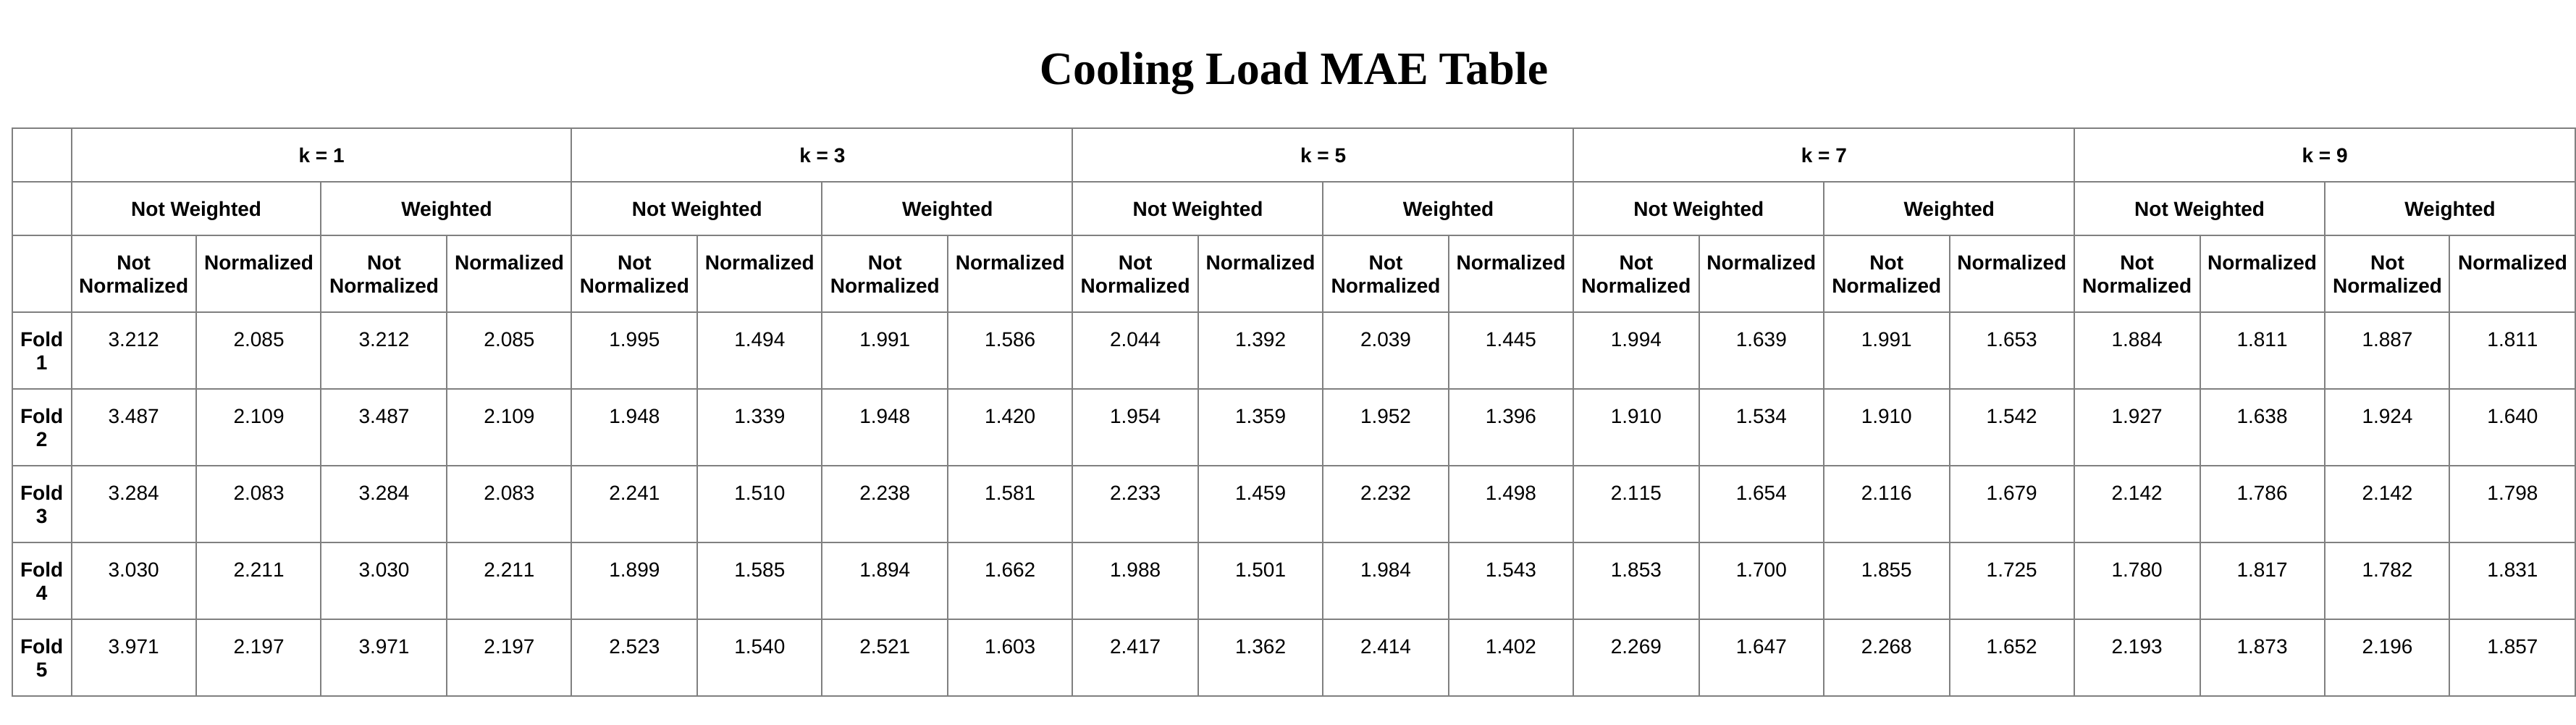

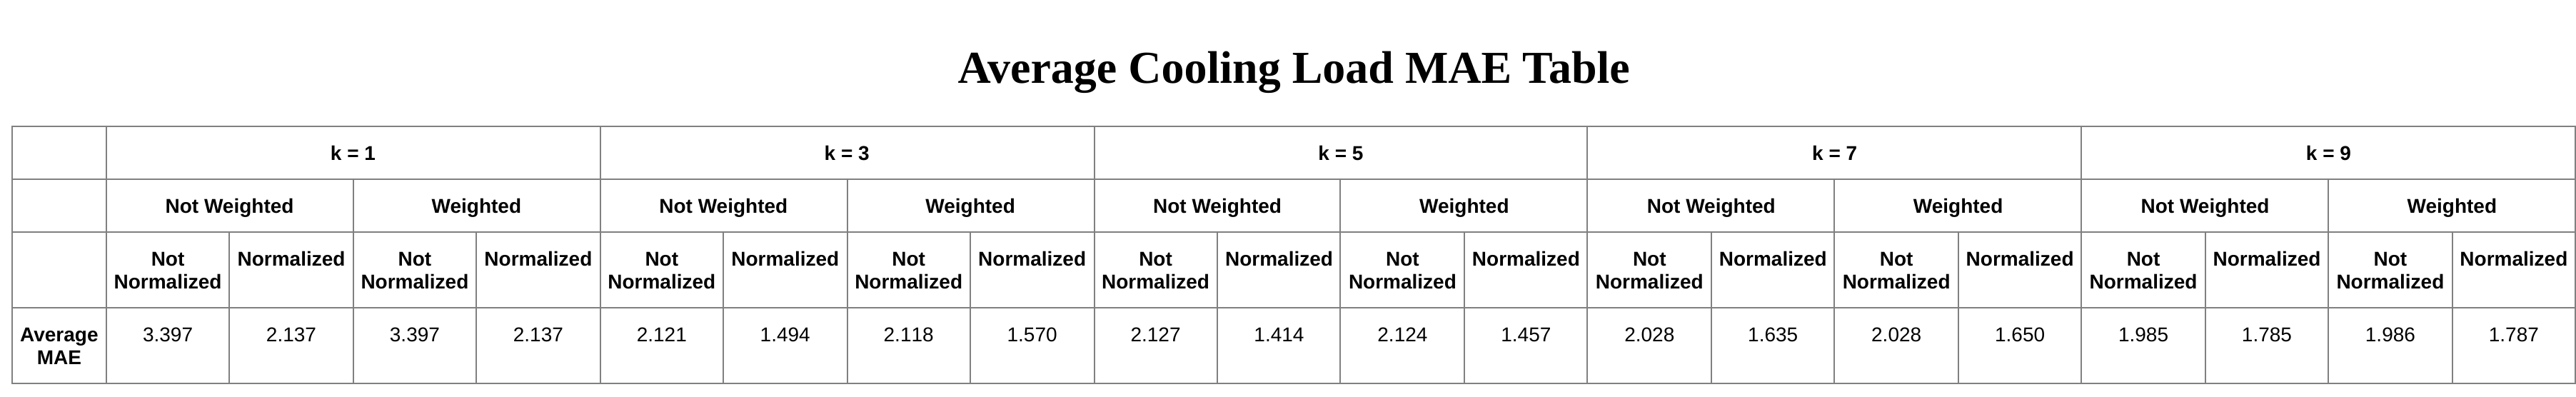

<h3 style="font-family: verdana"><b>2.6.4: Conclusion</b></h3>

<p style="font-family: verdana">If we compare the results of the weighted and unweighted KNN algorithms at the same K and normalized values in the table, we find that the outcomes are similar to each other. For instance, no k value in the table has a difference of more than 1. For example, the case of k = 1 and its folds. This might be because the distance has little to no impact on the outcome when the dataset's values are vectorized.</p>

<p style="font-family: verdana">On the regression, the normalization is making by shifting the values of each feature such that the smallest value is 0, then dividing by the maximal value and done to the 0–1 range. If we average the normalized and unnormalized numbers in the table, we can see that the normalized values consistently produce better results, while the difference is not much. The multiple intervals and outlier values of the data sets may be the reason. We can evaluate the data more precisely when we use a set interval.</p>

<p style="font-family: verdana">In conclusion, dataa normalization reduced the MAE value. Weighted KNN also reduced the MAE value compared to the normal KNN algorithm sometimes. However, this reduction is not much.</p>